In [74]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
import os
sys.path.append("../") # for importing utils and glm

import utils
from neurofit import utils as nfutils

from corner import corner

# plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

In [75]:
from models import cosstrf, GLM_cos

In [76]:
# load mcmc results
cell = "yg0616_9_B"
stim_type = "conspecific"

# load mcmc results
folder = "crcns_glm_l2a"
root = "/scratch/dstrf/results/"
path = "/".join([root,folder,cell,""])

results = {}
for f in next(os.walk(path))[2]:
    name, ext = f.split(".")
    if ext == "npz":
        results[name] = np.load(path+f)
        
#results = [f for f in next(walk(path))[2] if f.split(".")[1] == "npz"]
R = results[results.keys()[0]]
maxlik = R['map']
chain = R['chain']

In [77]:
# glm model settings
ncos = 10
spcos = 5
dt = 0.001
tcoslin = 1
hcoslin = 10
channels = 1

# data parameters 
nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
plen = int(np.rint(50/t_dsample))
psth_smooth = 5/t_dsample
compress = 1

num_assim_stims = 15

# setup cosine basis
tbas, fromt, tot = utils.cosbasis(tlen,ncos,tcoslin,retfn=True,norm=True)
hbas, fromh, toh = utils.cosbasis(plen,spcos,hcoslin,retfn=True)

# load data from crcns
stims,durations,spikes_data,spiky_data,names = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress,names=True)
psth_data = [utils.psth(spk,dur,t_dsample,dsample=t_dsample) for spk,st,dur in zip(spikes_data,stims,durations)]

# separate the simulation and validation sets
assim_psth, test_psth = np.split(psth_data,[num_assim_stims])
assim_spikes, test_spikes = np.split(spikes_data,[num_assim_stims])
assim_spiky, test_spiky = np.split(spiky_data,[num_assim_stims])
assim_stims, test_stims = stims[:num_assim_stims], stims[num_assim_stims:]
assim_dur, test_dur = np.split(durations,[num_assim_stims])

# calculate correlation between even and odd trial psths
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=psth_smooth) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

EO: 0.34


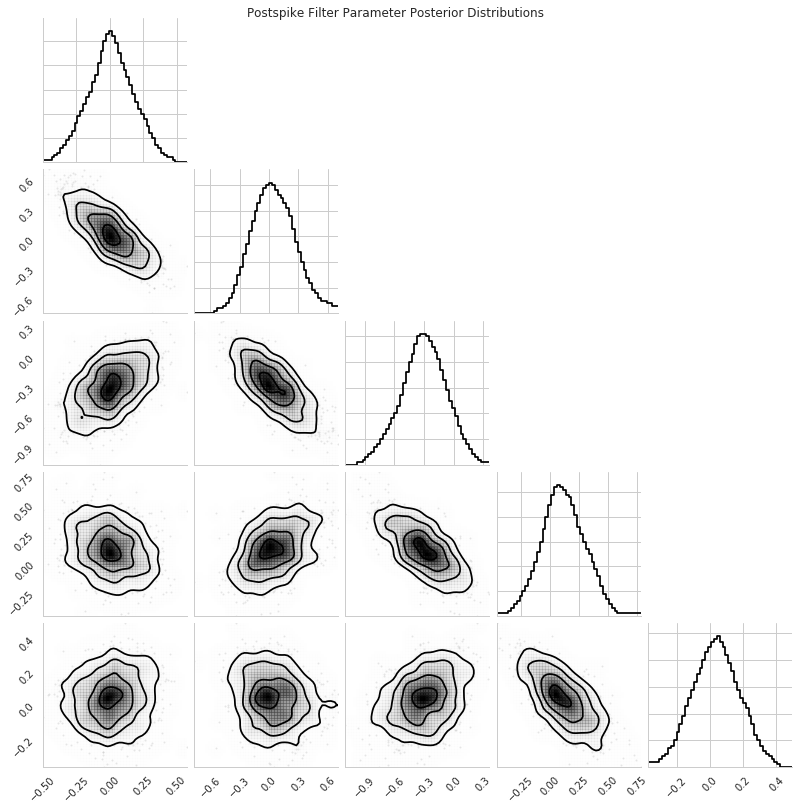

In [78]:
corner(chain[:,-spcos:],bins=50,
       #truths=maxlik[:4],
       smooth=2,smooth1d=2);
sns.despine(right=True)
suptitle("Postspike Filter Parameter Posterior Distributions")
#savefig("cm_neuron-corner.svg")

In [95]:
reload(utils)

<module 'utils' from '../utils.pyc'>

In [96]:
model = GLM_cos(channels,nspec,tlen,plen,ncos,spcos,tcoslin,hcoslin,nonlin=np.exp,spike=True,dt=dt)
model.set(maxlik)

map_corr = utils.glm_sample_validate(model,maxlik,test_stims,test_psth,ntrials=10,dsample=0,smooth=psth_smooth)
ppcorr = utils.glm_post_predict_corr(model,test_stims,test_psth,chain,1,psth_smooth,ntrials=10)
corr_means = np.mean([map_corr,ppcorr,eocorr[num_assim_stims:]],axis=1)
print("\nMAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))


MAP: 0.52, Dist: 0.52, EO: 0.34
MAP/EO: 1.50, Dist/EO: 1.51


In [ ]:
all_corr = []
figure(figsize=(16,10))
model.set(maxlik)

for s,p,k,i in zip(test_stims,test_psth,test_spiky,range(len(test_psth))):
    all_spky = []
    for _ in range(10):
        trace, spikes = model.run(s) 
        V, thresh = trace.T[:2]
        spky = pyspk.SpikeTrain(spikes,[0,len(p)])
        all_spky.append(spikes)
    psth = utils.psth(all_spky,len(p),smooth=psth_smooth,dsample=0)
    subplot(len(test_psth),1,i+1)
    plot(p-min(p),"k",label="data")
    plot(psth,"c",label="model")
    xlim(0,len(psth))
    title("R: {:.2f}".format(np.corrcoef(psth,p)[0][1]))
    xticks(range(0,len(psth),50),range(0,len(psth)*t_dsample,50*t_dsample))
    xlabel("ms")
    if i == 0: legend()


    
tight_layout()
subplots_adjust(top=0.90)
suptitle(cell)


In [ ]:
mu = np.mean(chain,axis=0)
med = np.median(chain,axis=0)

In [ ]:
from neurofit import graphics
import scipy as sp

In [ ]:
par = cosstrf(channels,nspec,tlen,ncos,tcoslin)
par.set(mu[1:-spcos])

figure(figsize=(9,6))
graphics.strf_plot(model.k.sfilt,model.k.tfilt,500,8000,5)
suptitle("Estimated STRF")

In [ ]:
title("Postspike Filter")
plot(fromh(mu[-spcos:]))